<a href="https://colab.research.google.com/github/rolozanod/mexico_fuel_guided_project/blob/main/Sessions/ProjectNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing the decision-making of a strategic project under uncertainty
### A Coursera Guided project
### by Rodrigo Lozano

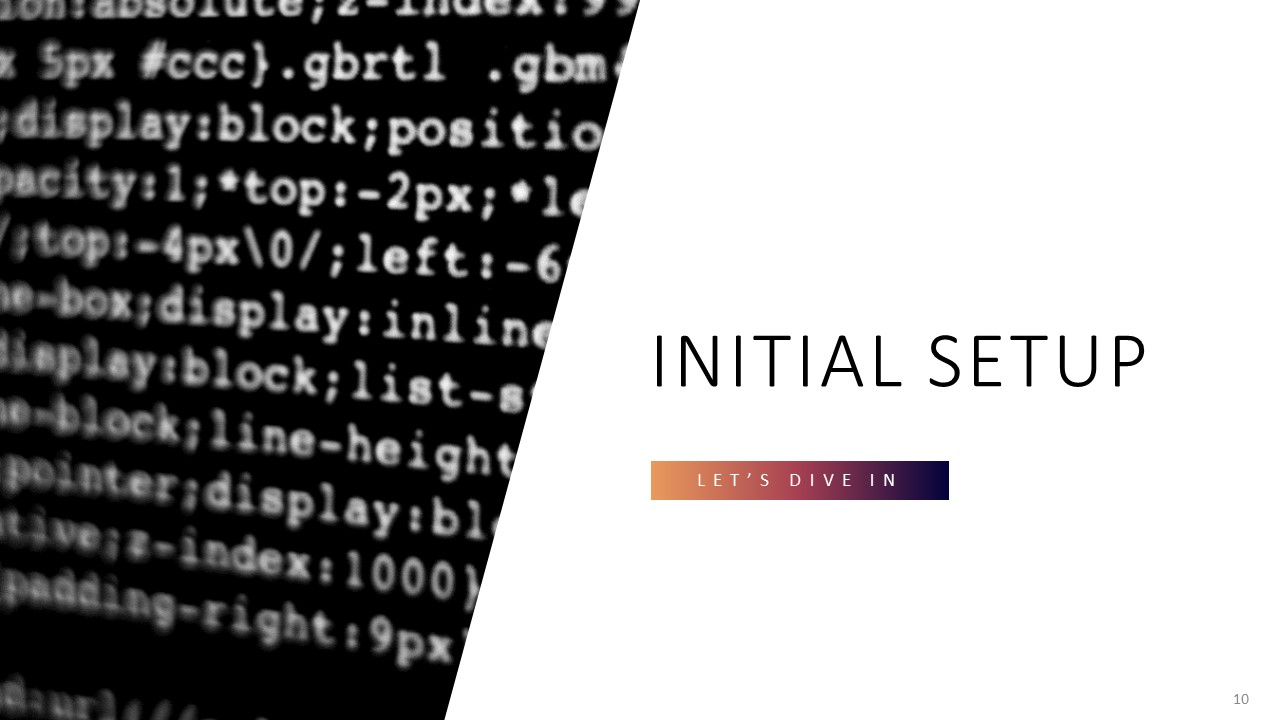


# Session 1: Initial setup

1. Retrieve project data from GitHub
  1. Sessions notebooks
  1. Fuel consumption, census and refineries data
1. Download Mexico´s location coordinates from INEGI
1. Download fuel price data
1. Manipulate the data
  1. Calculate daily fuel consumption
  1. Calculate daily fuel prices
  1. Estimate fuel consumption for missing states and estimate seasonality from prices
1. Filter and group the important locations by revenue to reduce complexity 
1. Merge all data into a dataframe

## Clone data form the GitHub project

In [ ]:
!git clone https://github.com/rolozanod/mexico_fuel_guided_project.git

Install required dependencies that are not by default in Google Colab

## Unzip files from data.zip
This folder was downloaded from the GitHub repository

In [ ]:
 !unzip /content/mexico_fuel_guided_project/data.zip -d /content/mexico_fuel_guided_project

Change directory

In [ ]:
import os
os.chdir('/content/mexico_fuel_guided_project')
os.getcwd()

In [ ]:
!ls

In [ ]:
!pip install geopandas
!apt-get install -y -qq glpk-utils

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from modules.sessions import ProjectSessions as sess

In [ ]:
coords = sess().get_coords()

## All done with setting up the environment, see you on the next video where we will shape the data into the desired model

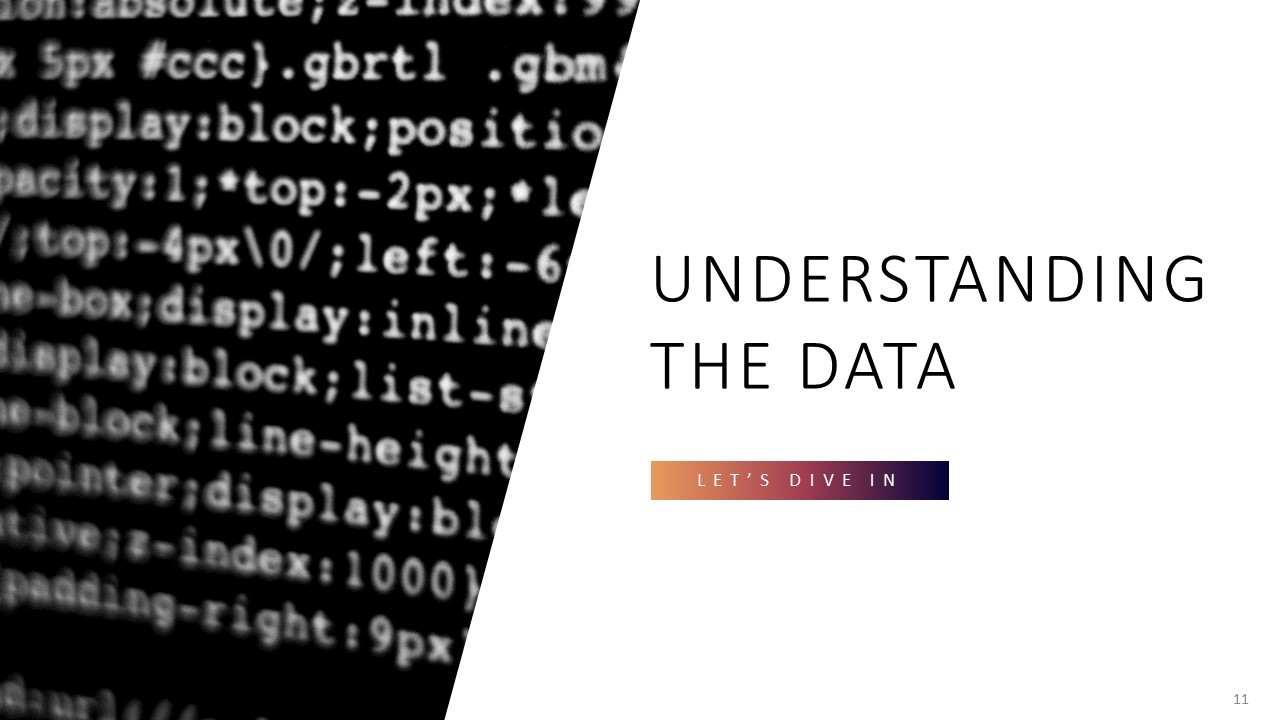

# Session 2: Understanding the data

1. Manipulate the data
  1. Calculate daily fuel consumption
  1. Calculate daily fuel prices
  1. Estimate fuel consumption for missing states and estimate seasonality from prices
1. Filter and group the important locations by revenue to reduce complexity 
1. Merge all data into a dataframe

## Calculate daily fuel consumption

Originally, fuel consumption is given daily per state.

The intention is to calculate this consumption by location using the `fuel consumption per capita`

* Fuel consumption: State-Day -> Location-Day
    * Given data:
        * Fuel consumption: State - Day
        * Population: Location
    1. Estimate fuel consumption per capita in the state
  $fpc = \textrm{fuel in state} / \textrm{people in state}$
    1. Map the state's cunsumption per capita into the locations
  $fpl = fpc \cdot \textrm{people in location}$

In [ ]:
sess().get_pop().sample(5)

In [ ]:
sess().get_demand().sample(5)

In [ ]:
sess().calc_fpc(sess().get_pop(), sess().get_demand(), regress = False).describe()

## Calculate daily fuel price

There are four sources of information for fuel price:
1. Daily national price average for each fuel type (diesel, reguular, premium)
1. Monthly state price for diesel
1. Monthly state price for regular
1. Monthly state price for premium

The intention is to calculate this price by location using the by coupling the avearges to solve for fuel price

* Fuel price: National-Day -> Location-Day
    * Given data:
        * Fuel price: National - Day
        * Fuel price: State - Month
    1. Extend the State-Month price into State-Day price using the daily info from Nation-Day data
    1. Map location coordinates into gas stations and groupby location
    1. Map monthly-daily data into location-daily data using the mapped location-station data

In [ ]:
sess().get_price_dataframe()

## Reduce complexity

The dataset will be aggregated to reduce the complexity of the optimization.

Calculate the treshhold of relevant locations given the share of revenue per state

This is done using the Box and Whisker methodology -> Q(50) + 1.5 x (Q(75) - Q(25))

This is cliped over the 10% and 90% range so no locations are found under 10% revenue and locations above 90% are not grouped

Relevant locations will mantain their name
Non-relevant locations will be named with the name state and the number of locations aggregated
* State (\# locations)

In [ ]:
df = sess().create_fuel_dataframe(min_share=0.1, keep_above=0.9)

In [ ]:
sess().plot_monthly_data(df)

## All done with working with the dataset, see you on the next video where we will fit the machine learning model

In [ ]:
del df, coords

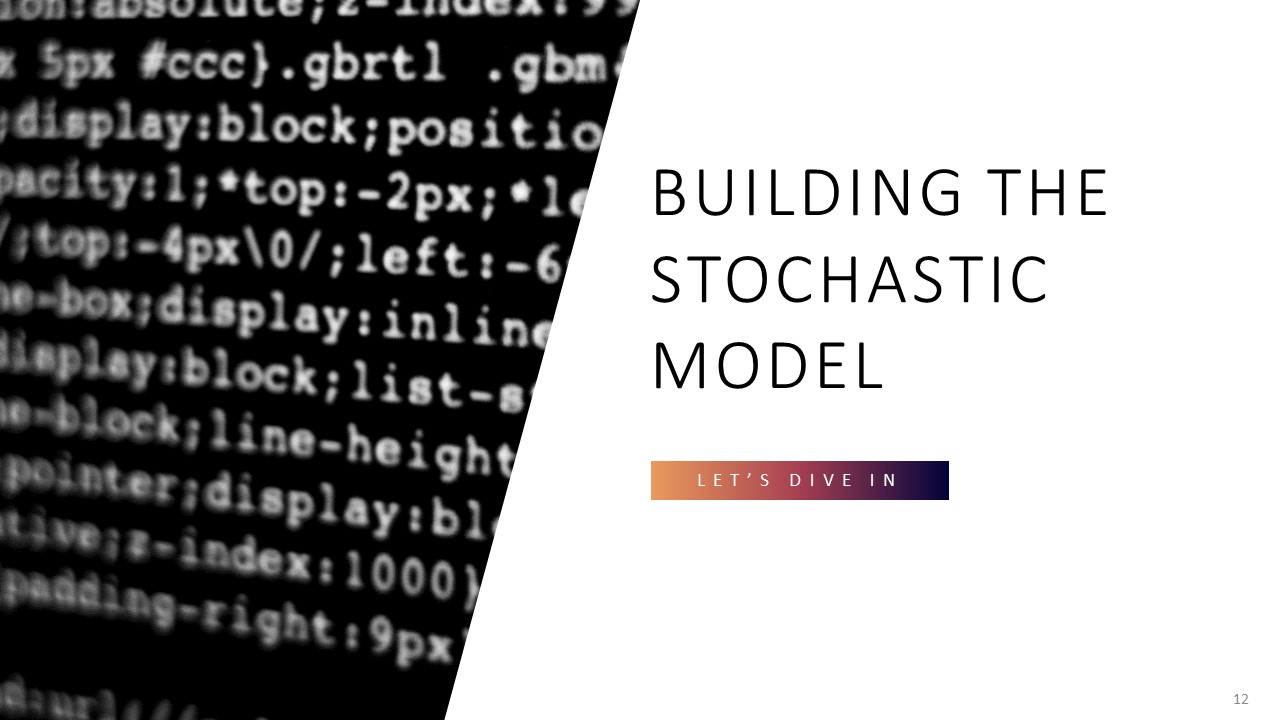

# Session 3 Building the stochastic model

1. Create the WindowGenerator object with reduced complexity
1. Create the VAE models for price and litres
1. Backtest the fitted models
1. Generate random samples

## Create a window generator object
This object is a variation from this __[Tensorflow Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)__

It is a deep dive into multiple approaches to predict timeseries

In [ ]:
BATCH_SIZE = 16 # number of windows per batch
FORECAST_WINDOW = 1 # days to forecast
HINGESIGHT_WINDOW = 7*8+1 # days used for prediction
# WARNING! The model implemented in this project is designed for a window of 56+1

w = sess().WindowGenerator(input_width=HINGESIGHT_WINDOW, label_width=FORECAST_WINDOW, batch=BATCH_SIZE, min_share=0.1, keep_above=0.9)

In [ ]:
w

## Create the VAE models

In [ ]:
FILTERS = 32 # number of filters for the convolution layers
KERNEL_SIZE = 15 # size of the convolution window (kernel)
STRIDES = 2 # number of timesteps to skip between samples
H_UNITS = 2**8 # size of the hidden neurons for prediction
LATENT_DIMS = 2**4 # size of the embedding

# vae blocks
# price
price_ts, price_encoder, price_decoder, price_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS)

# litres
litres_ts, litres_encoder, litres_decoder, litres_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS)

In [ ]:
# 80 epochs ~ 10 min
sess().train(price_vae, price_ts, litres_vae, litres_ts, window=w, MAX_EPOCHS = 80)

## Run the backtest

In [ ]:
#sess().load_weights(0, price_encoder, price_decoder, price_vae, litres_encoder, litres_decoder, litres_vae)
sess().run_backtest(price_vae, price_ts, litres_vae, litres_ts, window=w, plot=True)

In [ ]:
sess().save_weights(1, price_encoder, price_decoder, price_vae, litres_encoder, litres_decoder, litres_vae)

## Create and compare random samples 

In [ ]:
INIT_DATE = '2021-01-01'
FINAL_DATE = '2021-12-31'

sess().load_weights(0, price_encoder, price_decoder, price_vae, litres_encoder, litres_decoder, litres_vae)

price_ts_base, litres_ts_base = sess().forecast(price_vae, price_ts, litres_vae, litres_ts, window=w, init_date=INIT_DATE, final_date=FINAL_DATE, plot=True)

In [ ]:
# vae random blocks
# price
price_ts, price_encoder, price_decoder, price_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS, random=True, amplitude=20)

# litres
litres_ts, litres_encoder, litres_decoder, litres_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS, random=True, amplitude=100)

sess().load_weights(0, price_encoder, price_decoder, price_vae, litres_encoder, litres_decoder, litres_vae)

price_ts_rand, litres_ts_rand = sess().forecast(price_vae, price_ts, litres_vae, litres_ts, window=w, init_date=INIT_DATE, final_date=FINAL_DATE, plot=True)

In [ ]:
print(f'Price mean average percentage variation: {100*((price_ts_base.price - price_ts_rand.price).div(price_ts_base.price)).abs().mean():.2f}%')
print(f'Volume mean average percentage variation: {100*((litres_ts_base.litres - litres_ts_rand.litres).div(litres_ts_base.litres)).abs().mean():.2f}%')

## All done with creating samples using VAE, see you on the next video where we will optimize multiple scenarios

In [ ]:
del price_ts_base, price_ts_rand, litres_ts_base, litres_ts_rand

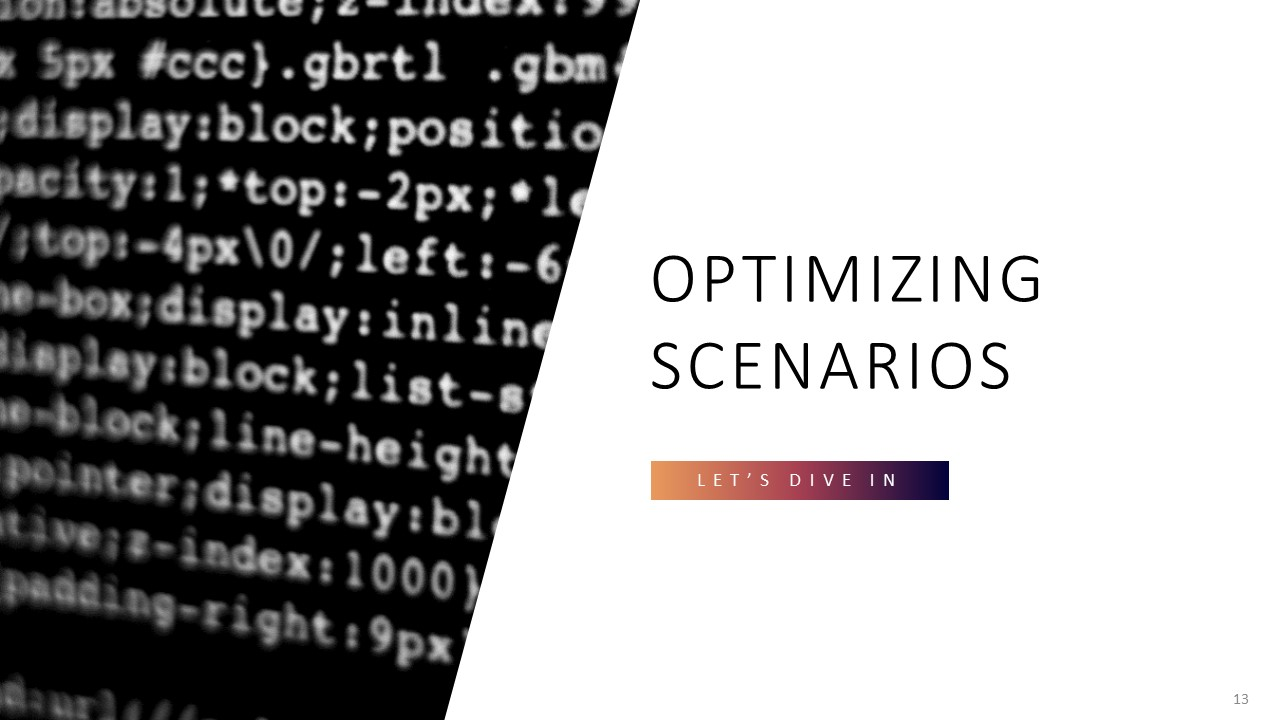

# Session 4 Optimizing scenarios

1. Create scenarios according to the objectives of the projects to evaluate
1. Estimate freight rates
1. Create the production random variables
1. Create the optmization model
1. Test the optimization model
1. Initiate the optimization loop

## Get the open source optimization algorithms for GLPK

This algorithms where installed with the `!apt-get install -y -qq glpk-utils` command.

The algorithms are from the __[GLPK open source project](https://www.gnu.org/software/glpk/)__.

The pyomo python package uses the GLPK engine to solve the optmization model.

## Import the required dependencies

In [ ]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import datetime
from tqdm.notebook import tqdm
import pyomo.environ as pme

## Create scenarios

We can create different scenarios as seen in last video.

But an optimization model that maximized on daily observations would be huge.

The model will be built to optmize monthly observations.

## Create a monthly time series

In [ ]:
opt_periods = 12

INIT_DATE = '2021-01-01'
FINAL_DATE = datetime.strptime(INIT_DATE, '%Y-%m-%d') + relativedelta(months=opt_periods) - relativedelta(days=1)

BATCH_SIZE = 16 # number of windows per batch
FORECAST_WINDOW = 1 # days to forecast
HINGESIGHT_WINDOW = 7*8+1 # days used for prediction

w = sess().WindowGenerator(input_width=HINGESIGHT_WINDOW, label_width=FORECAST_WINDOW, batch=BATCH_SIZE, min_share=0.1, keep_above=0.9)

In [ ]:
price, demand, period_stats = sess().monthly_data(version=0, window=w, init_date=INIT_DATE, final_date=FINAL_DATE, plot=True)

In [ ]:
period_stats

In [ ]:
demand.head()

## Estimate freight

The coordinates of each location are stored in the WindowGenerator object and the coordinates for the refineries are in the unzipped data, so we estimate the distance between them using the __[haversine function](https://en.wikipedia.org/wiki/Haversine_formula)__


In [ ]:
distances = sess().get_distances(window=w)

In [ ]:
demand.state.unique()

We will esteimate freight in a very simple way, having the distances we will define a cost per kilometer and we can modify specifically some locations if we want to do so be cause we have some extra information on the regions geography or highways.

In [ ]:
overall_mxnxton_kms = 0.2 # MXN/(Ton-Km)
pipe_size = 20000 # (L/trip) 
fuel_weight = (0.8508+0.7489)/2/1000 # (Ton/L) = (Kg/L)/(1 Ton/1000 Kg) 0.8508 is for fuel, 0.7489 is for gasoline

### trip = 20,000 litres ###

tonsxpipe = pipe_size*fuel_weight # (Ton/trip) = (L/trip)*(Ton/L)
print(f'Ton/Pipe: {tonsxpipe}')
overall_mxnxkms = overall_mxnxton_kms*tonsxpipe # MXN/(Km-trip) = MXN/(Ton-Km)*(Ton/trip)
print(f'MXN/Km-trip: {overall_mxnxkms}')
overall_mxnxkms_L = overall_mxnxkms/pipe_size # MXN/(Km-L) = MXN/(Km-trip)/(L/trip)
print(f'MXN/Km-L: {overall_mxnxkms_L}')

freight = distances.copy()
freight['freightxkms'] = overall_mxnxkms_L
        
freight['freight'] = freight['kms']*freight['freightxkms']
print('\nFreight description:\n', freight.loc[freight.source.str.contains('Refinery')&~freight.destination.str.contains('Refinery')].freight.describe())

In [ ]:
specific_states_rates = {
    'Baja California': 1.2, # Peninsula
    'Baja California Sur': 1.5, # Peninsula
    'Yucatán': 1.3, # Peninsula
    'Oaxaca': 1.2, # Mountain range
    'San Luis Potosí': 0.85 # Logistics hub
}

specific_state_connection_rates = {
    ('Baja California', 'Baja California Sur'): 1.3, # Mountain range
    ('Oaxaca', 'Baja California Sur'): 0.2, # Vessel
    ('Tamaulipas', 'Yucatán'): 0.2, # Vessel
    ('Veracruz de Ignacio de la Llave', 'Yucatán'): 0.2, # Vessel
}

freight = sess().fix_freight(w, freight, overall_mxnxkms_L, specific_state_connection_rates, specific_states_rates)
freight.head()

In [ ]:
freight.loc[(freight.freightxkms==overall_mxnxkms_L*0.2)]

## Create production variables

In [ ]:
production = sess().get_refinery_data()
production

## Fixed costs

In [ ]:
fixed = 500000
fixed_costs_dict = {'fixed': {
    'Cadereyta Refinery': 5.0,
    'Madero Refinery': 5.0,
    'Tula Refinery': 5.0,
    'Salamanca Refinery': 5.0,
    'Minatitlan Refinery': 5.0,
    'Salina Cruz Refinery': 5.0,
    'Cangrejera Refinery': 5.0,
    'Dos Bocas Refinery': 5.0
}}

production = pd.merge(
    left=production,
    right=pd.DataFrame(fixed_costs_dict),
    left_on = 'loc',
    right_index=True
).assign(fixed=lambda r: r.daily_capacity*r.fixed*30+fixed)
production.assign(u_fixed=lambda r: r.fixed.div(r.daily_capacity*30))

## Variable costs

In [ ]:
variable = 2.0
variable_costs_dict = {'variable': {
    'Cadereyta Refinery': 0.7/1e7,
    'Madero Refinery': 0.7/1e7,
    'Tula Refinery': 0.7/1e7,
    'Salamanca Refinery': 0.7/1e7,
    'Minatitlan Refinery': 0.7/1e7,
    'Salina Cruz Refinery': 0.7/1e7,
    'Cangrejera Refinery': 0.7/1e7,
    'Dos Bocas Refinery': 0.7/1e7
}}

production = pd.merge(
    left=production,
    right=pd.DataFrame(variable_costs_dict),
    left_on = 'loc',
    right_index=True
).assign(variable=lambda r: r.daily_capacity*r.variable+variable)
production

## Storage capacity

In [ ]:
storage = 500000
storage_dict = {'storage': {
    'Cadereyta Refinery': 15, # capacity in terms of production days
    'Madero Refinery': 15,
    'Tula Refinery': 15,
    'Salamanca Refinery': 15,
    'Minatitlan Refinery': 15,
    'Salina Cruz Refinery': 15,
    'Cangrejera Refinery': 15,
    'Dos Bocas Refinery': 15
}}

production = pd.merge(
    left=production,
    right=pd.DataFrame(storage_dict),
    left_on = 'loc',
    right_index=True
).assign(storage=lambda r: r.daily_capacity*r.storage+storage)
production

## Safety inventories when the plant is running

In [ ]:
safety_inventory = 100000
safety_inventory_dict = {'safety_inventory': {
    'Cadereyta Refinery': 1,
    'Madero Refinery': 1,
    'Tula Refinery': 1,
    'Salamanca Refinery': 1,
    'Minatitlan Refinery': 1,
    'Salina Cruz Refinery': 1,
    'Cangrejera Refinery': 1,
    'Dos Bocas Refinery': 1
}}

production = pd.merge(
    left=production,
    right=pd.DataFrame(safety_inventory_dict),
    left_on = 'loc',
    right_index=True
).assign(safety_inventory=lambda r: r.daily_capacity*r.safety_inventory+safety_inventory)
production

## Production time series

In [ ]:
t = 0
production['T'] = t
production['days'] = period_stats.loc[period_stats['T']==t].days.values[0]
production_base = production.copy()
for t in range(1,opt_periods):
    days = period_stats.loc[period_stats['T']==t].days.values[0]
    production = pd.concat(
        [production, production_base.assign(
            T=t,
            days=days,
            fixed=lambda r: r.fixed*(1.05)**t,
            variable=lambda r: r.variable*(1.07)**t,
        )], axis = 0
    )
production.reset_index(drop=True, inplace=True)
production['capacity'] = production['daily_capacity']*production['days']
production

## CAPEX Projects  

In [ ]:
capex_projects = {'capex': {
    'Cadereyta Refinery': 0,
    'Madero Refinery': 0,
    'Tula Refinery': 0,
    'Salamanca Refinery': 0,
    'Minatitlan Refinery': 0,
    'Salina Cruz Refinery': 0,
    'Cangrejera Refinery': 0,
    'Dos Bocas Refinery': 8900*20*1e6
    }
}

capex_projects = pd.DataFrame(capex_projects)

capex_projects['type'] = 'INITIAL'
capex_projects

In [ ]:
strategic_projects = {'capex': {
    'Cadereyta Refinery': 35e9,
    'Madero Refinery': 20e9,
    'Tula Refinery': 20e9,
    'Salamanca Refinery': 15e9,
    'Minatitlan Refinery': 10e9,
    'Salina Cruz Refinery': 10e9,
    'Cangrejera Refinery': 10e9,
    'Dos Bocas Refinery': 0
    },
    'increment': {
    'Cadereyta Refinery': 1.5,
    'Madero Refinery': 1.5,
    'Tula Refinery': 1.5,
    'Salamanca Refinery': 1.5,
    'Minatitlan Refinery': 1.5,
    'Salina Cruz Refinery': 1.5,
    'Cangrejera Refinery': 1.5,
    'Dos Bocas Refinery': 0
    }
}

strategic_projects = pd.DataFrame(strategic_projects)

strategic_projects['type'] = 'STRATEGIC'
strategic_projects

In [ ]:
projects = pd.concat(
    [capex_projects, strategic_projects],
    axis=0
)
projects.index.names = ['loc']

projects = projects.reset_index()
projects

## Quick sanity checks before optimizing

In [ ]:
print(f'Capacity/Demand: {100*production.capacity.sum()/demand.litres.sum():,.2f}%')

In [ ]:
print('Capacity/Demand: \n', 100*production.groupby(['T']).capacity.sum()/demand.groupby(['T']).litres.sum())

In [ ]:
print('Sold out costs description:\n', (production.fixed/production.capacity+production.variable).replace(np.inf, np.nan).describe())

In [ ]:
print('Highest freight locations:\n', freight.loc[freight.source.str.contains('Refinery')&~freight.destination.str.contains('Refinery')].groupby(['destination']).agg({'freight': 'min'}).sort_values(by='freight', ascending=False).head(10))
print('\nFreight description:\n', freight.loc[freight.source.str.contains('Refinery')&~freight.destination.str.contains('Refinery')].freight.describe())

In [ ]:
print('Lowest price locations:\n', price.set_index('loc').price.sort_values(ascending=True).head(10))
print('\nPrice description:\n', price.price.describe())

In [ ]:
REFINERIES=list(production['loc'].drop_duplicates().values)
LOCATIONS=list(demand['loc'].drop_duplicates().values)

WACC = 0.1
depreciation_years=10
minimum_production_period=3

opt_timelimit=60*5
mip_tolerance=1e-4

save_path="scenarios/"
opt_version='baseline'
step=0
pbar = tqdm(range(1)) 

fuel_opt = sess().get_fuel_opt_model(opt_periods, REFINERIES, LOCATIONS, demand, price, freight, production, projects, WACC, depreciation_years, minimum_production_period, step=step, pbar=pbar)

In [ ]:
sess().optimize_MIP_model(fuel_opt, opt_timelimit, mip_tolerance, save_path, opt_version, step, pbar)

In [ ]:
demand_stats, market_stats, prod_stats, inter_facilites, objective = sess().retrieve_opt_info(fuel_opt)

In [ ]:
market_stats.sales.sum()

In [ ]:
prod_stats.production.sum()

In [ ]:
prod_stats.loc[(slice(None), 'Dos Bocas Refinery'),:]

In [ ]:
prod_stats.production.sum()

In [ ]:
prod_stats.capex.sum()

In [ ]:
prod_stats.expansion.sum()

## Now that you know how to optimize a sinlge scenario, lets wrap those functions into a loop to iteratively solve for different scenario to make an assesment

The analysis should be done on the long term so the optimization periods will be extended to 5 years and run yearly because of computing resources restrictions

In [ ]:
opt_periods = 6

INIT_DATE = '2021-01-01'
FINAL_DATE = datetime.strptime(INIT_DATE, '%Y-%m-%d') + relativedelta(months=opt_periods*12) - relativedelta(days=1)

BATCH_SIZE = 16 # number of windows per batch
FORECAST_WINDOW = 1 # days to forecast
HINGESIGHT_WINDOW = 7*8+1 # days used for prediction

w = sess().WindowGenerator(input_width=HINGESIGHT_WINDOW, label_width=FORECAST_WINDOW, batch=BATCH_SIZE, min_share=0.1, keep_above=0.9)

WACC = 0.1
depreciation_years=10
minimum_production_months=3

opt_timelimit=60*5
mip_tolerance=1e-4

save_path="scenarios/"
opt_versions=['baseline', 'optimal']
n_scenarios = 20

pbar = tqdm(range(n_scenarios))

for opt_version in opt_versions:
    if not os.path.exists(save_path+opt_version+'/demand/'):
        os.makedirs(save_path+opt_version+'/demand/')

    if not os.path.exists(save_path+opt_version+'/market/'):
        os.makedirs(save_path+opt_version+'/market/')

    if not os.path.exists(save_path+opt_version+'/production/'):
        os.makedirs(save_path+opt_version+'/production/')

    if not os.path.exists(save_path+opt_version+'/objective/'):
        os.makedirs(save_path+opt_version+'/objective/')

    if not os.path.exists(save_path+opt_version+'/ts_specs/'):
        os.makedirs(save_path+opt_version+'/ts_specs/')

for step in pbar:
        
    next_step = False

    while next_step == False:

        price, demand, period_stats = sess().annual_data(version=0, window=w, init_date=INIT_DATE, final_date=FINAL_DATE, plot=True, p_pbar=pbar)

        freight = sess().build_freight_costs(w, overall_mxnxton_kms=0.5)

        production = sess().production_timeseries(opt_periods,
                                                 period_stats,
                                                 fixed_base=10000000*12,
                                                 fixed_ratio=1.5*12,
                                                 variable_base=1.5,
                                                 variable_ratio=3.0/1e7,
                                                 storage_base=500000,
                                                 storage_ratio=30,
                                                 safety_inventory_base=100000,
                                                 safety_inventory_ratio=5
                                                 )

        REFINERIES=list(production['loc'].drop_duplicates().values)

        LOCATIONS=list(demand['loc'].drop_duplicates().values)

        for baseline_model in [False, True]:
            
            next_model = False
            
            while next_model == False:

                fuel_opt = sess().get_fuel_opt_model(opt_periods, REFINERIES, LOCATIONS, demand, price, freight, production, projects, WACC, depreciation_years, minimum_production_months, step=step, pbar=pbar, annual=True, baseline=baseline_model)

                results, last_mip_gap = sess().optimize_MIP_model(fuel_opt, opt_timelimit, mip_tolerance, save_path, opt_version, step, pbar, verbose=False)

                if results['Solver'][0]['Termination condition'].value not in ['infeasible']:

                    opt_version = {True: 'baseline', False: 'optimal'}[baseline_model]

                    demand_stats, market_stats, prod_stats, _, objective = sess().retrieve_opt_info(fuel_opt)

                    demand_stats.index.names = ['T', 'loc']
                    demand_stats.reset_index().to_csv(save_path+opt_version+f"/demand/scenario_{step}.csv", index = False)

                    period_stats.to_csv(save_path+opt_version+f"/ts_specs/stats.csv")

                    market_stats.index.names = ['T', 'loc', 'plant']
                    market_stats.reset_index().to_csv(save_path+opt_version+f"/market/scenario_{step}.csv", index = False)

                    prod_stats.index.names = ['T', 'plant']
                    prod_stats.reset_index().to_csv(save_path+opt_version+f"/production/scenario_{step}.csv", index = False)

                    objective.assign(step=step).to_csv(save_path+opt_version+f"/objective/scenario_{step}.csv", index = False)
                    
                    next_model = True

        next_step = True

## All done with the scenario optimization, see you in the next video where we will analyze the results

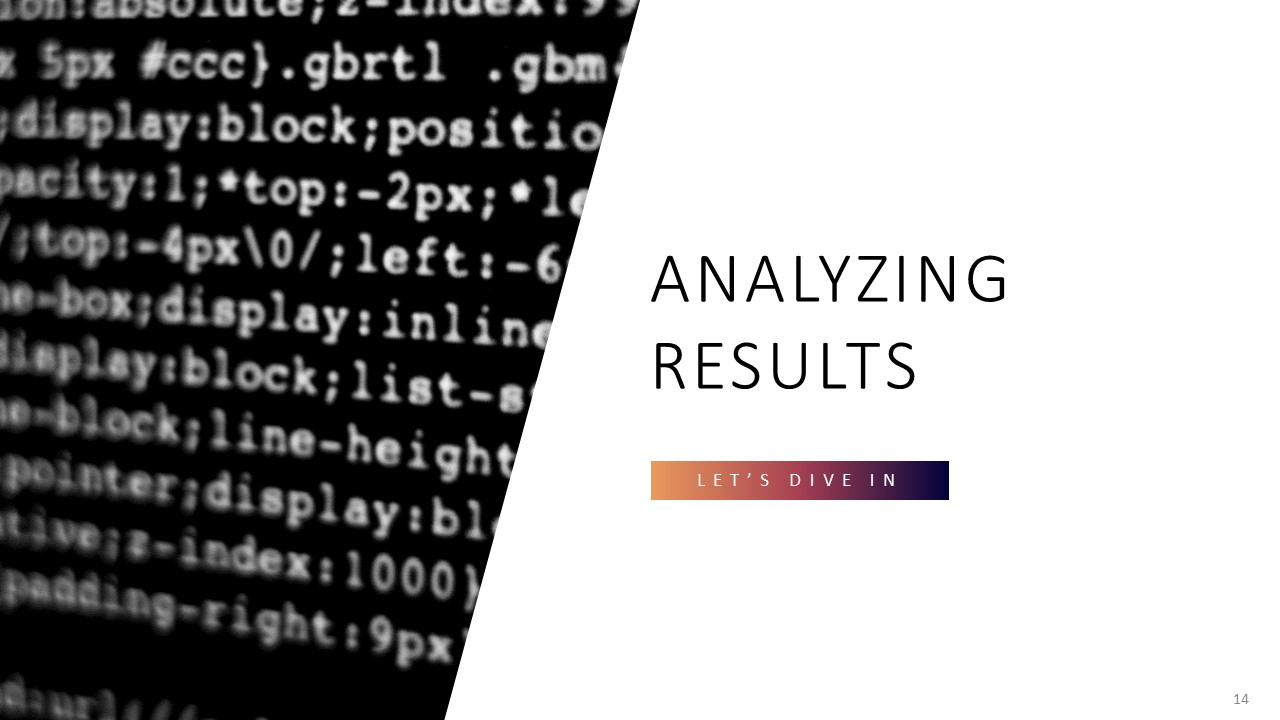

# Session 5 Analyzing the results

1. Load the saved data
1. Plot relevant information
1. Run infernece tests

In [ ]:
import matplotlib.pyplot as plt

## Load the saved scenarios

In [ ]:
save_path="scenarios/"
market_stats, _, prod_stats, _, period_stats = sess().load_opt_valuation(save_path)
opt_market_stats, demand_stats, opt_prod_stats, objective, _ = sess().load_opt_info(save_path, 'optimal')

## Plot relevant information

In [ ]:
sess().plot_market_consumption(opt_market_stats, demand_stats, period_stats)

In [ ]:
sess().plot_objective_hist(objective)

In [ ]:
sess().plot_plant_production_plan(opt_prod_stats, period_stats)

In [ ]:
sess().plot_plant_performance(opt_prod_stats, period_stats)

In [ ]:
sess().plot_plant_performance(prod_stats, period_stats)

## Sensitivity analysis

In [ ]:
sess().sensitivity_diagram(prod_stats, period_stats, WACC)

## Simulation analysis

In [ ]:
benefits, costs = sess().mc_simulation(prod_stats, period_stats, WACC)

## Real Option valuation

In [ ]:
T = 1
rf = 0.08

npvs, call = sess().real_opt_valuation(prod_stats, benefits, costs, projects, rf, T)

## We are done and we have the necesary information to make some suggestions and define the next steps

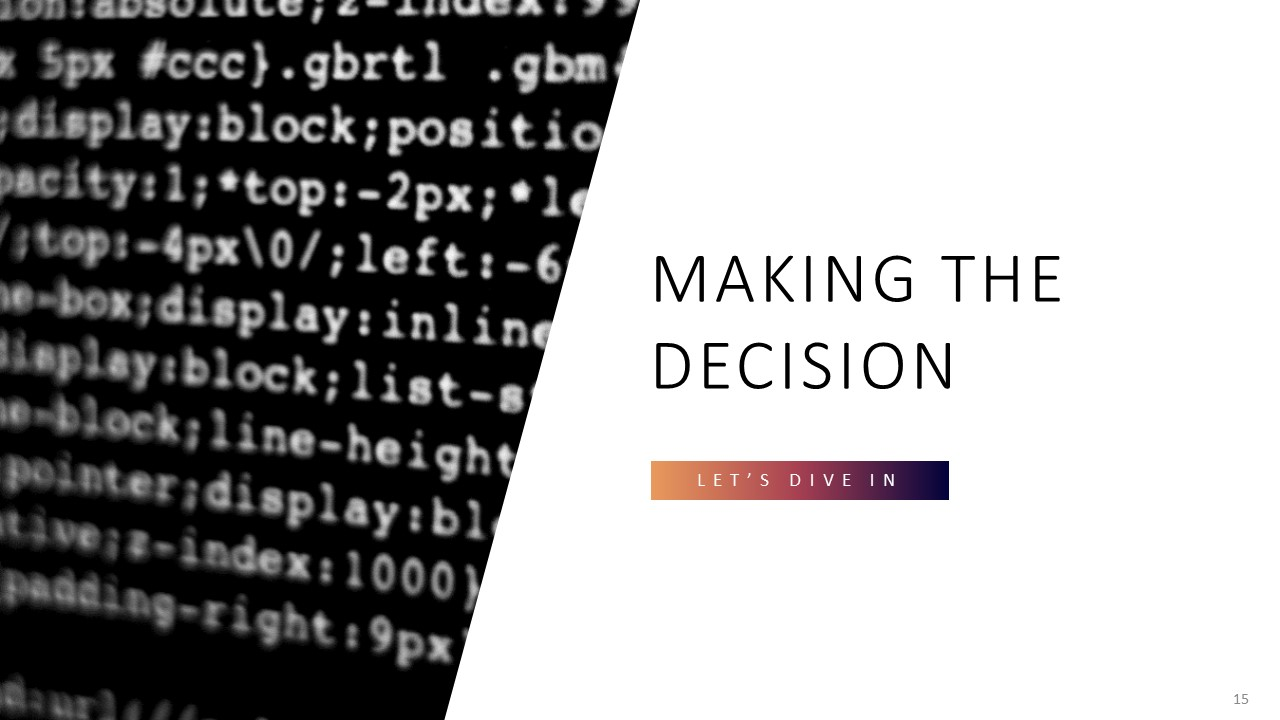

# Session 6 Making the decision

1. Review the project to identify the assumptions within the results
1. Make some suggestions with the available information
1. Define the next steps to improve our suggestions

## Assumptions

1. Demand was estimated with the population of each location
1. Prices were estimated by projecting the average monthly value per state given the national daily prices
1. Capacities are approximated with the production of 2020
    1. Dos Bocas capacity was retrievd from a newspaper article
1. All costs (variable, fixed, freight) are trivial and do not represent the actual ones
1. All CAPEX costs and capacities are trivial and do not represent the actual ones
    1. Dos bocas CAPEX was retrievd from a newspaper article
1. WACC and risk free rate are trivial and do not represent the actual ones
1. Valuation horizon was defined at 5 years given computing and time resources

## Suggestions
1. According to current data and with a valutaion horizon of 5 years:
    1. Dos Bocas refinery is not profitable and should not be built
    1. 

## Next steps

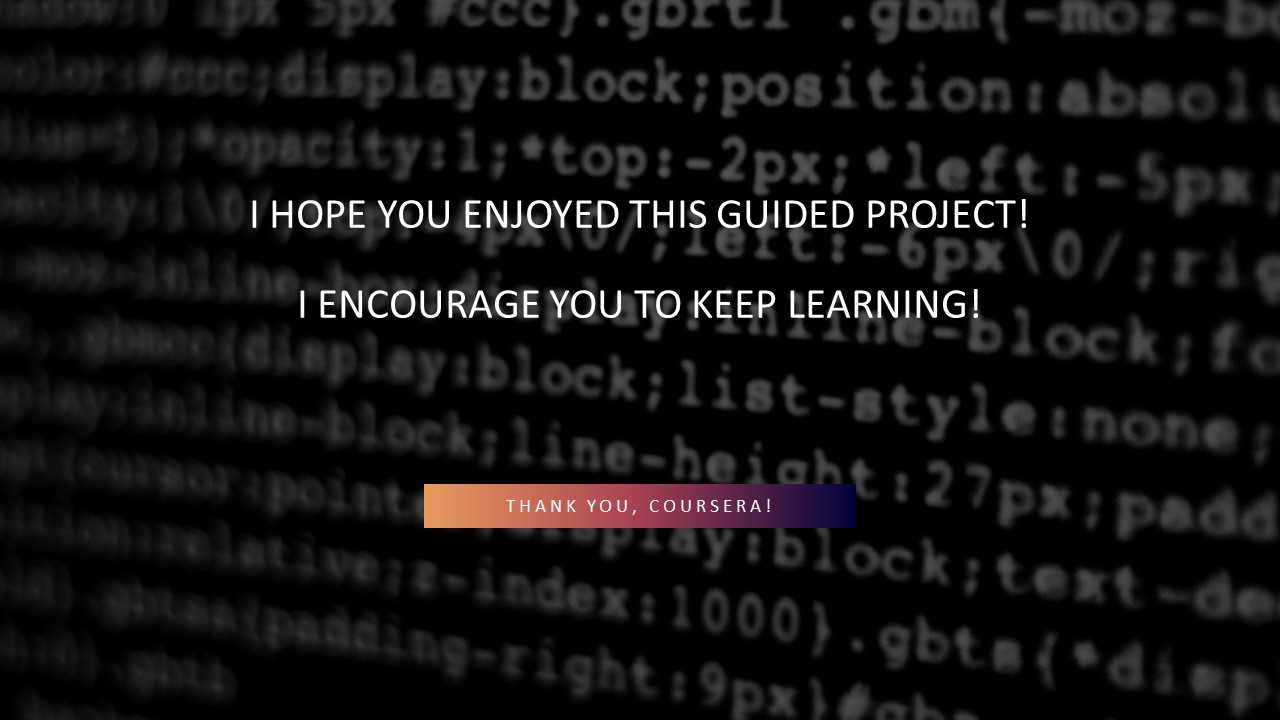

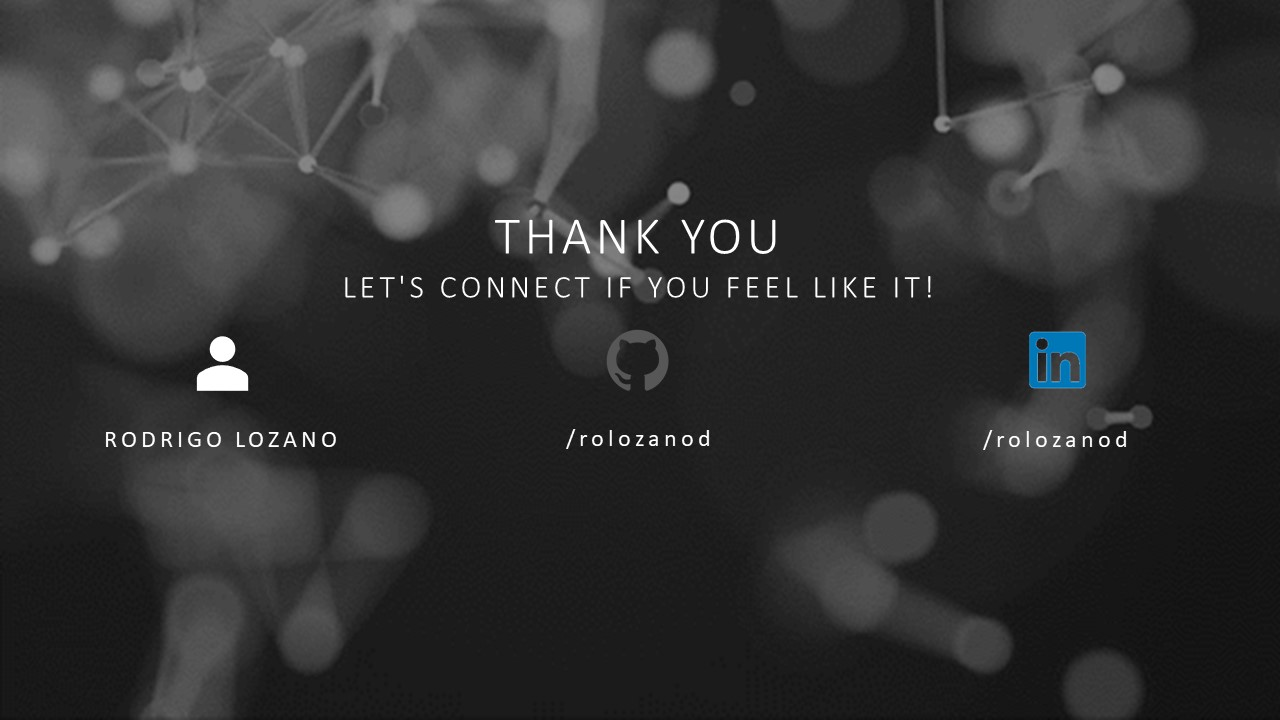